Base PSO

In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
from pyswarms.single import GlobalBestPSO, LocalBestPSO
import random

class Schedule:
    def __init__(self, hardConstraintPenalty):
        self.hardConstraintPenalty = hardConstraintPenalty
        self.intakes = ['Jan', 'Mar', 'Jun', 'Aug', 'Oct']
        self.programme = ['SE', 'DSBA']
        self.modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'IA', 'NDP', 'RMCE | RMCP', 'BDAT', 'DM', 'MDA | NLP', 
                       'BIS', 'AML', 'MMDA', 'DAP', 'ABAV', 'BSSMMA | CIS', 'TSF | DL', 'SEM | DPM', 'ORO | BIA']
        self.slot_intake = 4
        
        # Load both SE and DSBA student data
        self.SE_students_data = self.load_SE_student_data()
        self.DSBA_students_data = self.load_DSBA_student_data()
        
        # Process both SE and DSBA student data
        self.SE_incomplete_modules, self.SE_completed_modules = self.process_SE_student_data()
        self.DSBA_incomplete_modules, self.DSBA_completed_modules = self.process_DSBA_student_data()
                  
    def __len__(self):
        return len(self.intakes) * self.slot_intake * len(self.programme)
    
    def getIntakeSchedule(self, schedule):
        programme_schedule = {programme: {intake: [] for intake in self.intakes} for programme in self.programme}
        index = 0

        for programme in self.programme:
            for intake in self.intakes:
                for _ in range(self.slot_intake):
                    if index < len(schedule):
                        module = self.modules[schedule[index]]
                        programme_schedule[programme][intake].append(module)
                        index += 1
        return programme_schedule
    
    def load_SE_student_data(self):
        SE_students_data = pd.read_excel("data_v1.xlsx")
        SE_students_data = SE_students_data[SE_students_data['COURSE_DESCRIPTION'] != 'MSc in Data Science and Business Analytics']
        SE_students_data = SE_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Managing Software Development Projects': 'MSDP',
            'Reliability Management': 'RM',
            'Object-Oriented Software Systems Engineering': 'OOSSE',
            'Object Oriented Software Systems Engineering': 'OOSSE',
            'Software Engineering Support Environments': 'SESE',
            'Software Quality Engineering': 'SQE',
            'Security Technologies': 'ST',
            'Research Methodology in Computing and Engineering': 'RMCE | RMCP',
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Internet Applications': 'IA',
            'Natural Language Processing': 'MDA | NLP',
            'Network Design and Performance': 'NDP'
        }

        SE_students_data['MODULE_NAME'] = SE_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'RMCE | RMCP', 'BDAT', 'DM', 'IA', 'MDA | NLP', 'NDP']
        SE_students_data = SE_students_data[SE_students_data['MODULE_NAME'].isin(valid_modules)]

        # Handle duplicates
        duplicated_modules = SE_students_data[SE_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)

        SE_students_data = pd.concat([SE_students_data.drop(index=duplicated_modules.index), filtered_students])
        SE_students_data.reset_index(drop=True, inplace=True)
                
        return SE_students_data
    
    def process_SE_student_data(self):
        SE_each_student_info = self.SE_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()
        
        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in SE_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)
        
        # Handle elective modules
        elective = ["BDAT", "DM", "IA", "MDA | NLP", "NDP"]
        for student_id, completed_modules_info in completed_modules.items():
            completed_elective = set(completed_modules_info) & set(elective)

            if len(completed_elective) >= 3:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)
        
        return incomplete_modules, completed_modules
    
    def calculate_SE_student_violations(self, programme_schedule):
        total_violations = 0
        se_schedule = programme_schedule['SE']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.SE_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0
            
            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(se_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 1
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 1)
            # Or if RMCE | RMCP is already completed, reduce violations by 1
            elif (student_id in self.SE_completed_modules and 
                'RMCE | RMCP' in self.SE_completed_modules[student_id]):
                violations = max(0, violations - 1)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations

    def load_DSBA_student_data(self):
        DSBA_students_data = pd.read_excel("data_v1.xlsx")
        DSBA_students_data = DSBA_students_data[DSBA_students_data['COURSE_DESCRIPTION'] != 'MSc in Software Engineering']
        DSBA_students_data = DSBA_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Business Intelligence Systems': 'BIS',
            'Applied Machine Learning': 'AML',
            'Applied Machine Learning ': 'AML',
            'Research Methods for Capstone Project': 'RMCP',
            'Research Methodology for Capstone Project': 'RMCP',
            'Research Methodology in Computing and Engineering': 'RMCP',
            'Research Methodology': 'RMCP',
            'Research Methods for Capstone Project': 'RMCP',
            'Multivariate Methods for Data Analysis': 'MMDA',
            'Data Analytical Programming': 'DAP',
            'Advanced Business Analytics and Visualization': 'ABAV',
            'Advanced Business Analytics and Visualisation': 'ABAV',
            'Behavioural Science, Social Media and Marketing Analytics': 'BSSMMA',
            'Behavioural Science,Social Media and Marketing Analytics': 'BSSMMA',
            'Cloud Infrastructure and Services': 'CIS',
            'Time Series Analysis and Forecasting': 'TSF',
            'Time Series Analysis and Forecasting ': 'TSF',
            'Deep Learning': 'DL',
            'Multilevel Data Analysis': 'MDA',
            'Natural Language Processing': 'NLP',
            'Strategies in Emerging Markets': 'SEM',
            'Data Protection and Management': 'DPM',
            'Operational Research and Optimisation': 'ORO',
            'Operational Research Optimisation': 'ORO',
            'Building IoT Applications': 'BIA'
        }

        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['BDAT', 'DM', 'BIS', 'AML', 'RMCP', 'MMDA', 'DAP', 'ABAV', 'BSSMMA', 'CIS',
                        'TSF', 'DL', 'MDA', 'NLP', 'SEM', 'DPM', 'ORO', 'BIA']
        DSBA_students_data = DSBA_students_data[DSBA_students_data['MODULE_NAME'].isin(valid_modules)]
        
        duplicated_modules = DSBA_students_data[DSBA_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]

        # Handle duplicated
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grade function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)
        DSBA_students_data = pd.concat([DSBA_students_data.drop(index=duplicated_modules.index), filtered_students])

        # Handle DSBA special cases
        DSBA_students_data = self.handle_DSBA_special_cases(DSBA_students_data)

        # Final module name changes
        final_module_changes = {
            'RMCP': 'RMCE | RMCP',
            'NLP': 'MDA | NLP',
            'MDA': 'MDA | NLP',
            'BSSMMA': 'BSSMMA | CIS',
            'CIS': 'BSSMMA | CIS',
            'TSF': 'TSF | DL',
            'DL': 'TSF | DL',
            'SEM': 'SEM | DPM',
            'DPM': 'SEM | DPM',
            'ORO': 'ORO | BIA',
            'BIA': 'ORO | BIA'
        }
        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(final_module_changes)
        
        return DSBA_students_data

    def handle_DSBA_special_cases(self, df):
        # Function to check if student has specific modules
        def has_modules(group, module_set):
            return module_set.issubset(group['MODULE_NAME'].unique())

        # Handle BSSMMA, TSF, CIS case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "CIS"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'CIS')
        df = df[~rows_to_drop]
        
        # Handle BSSMMA, TSF, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'DL')
        df = df[~rows_to_drop]

        # Handle TSF, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"TSF", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'TSF')
        df = df[~rows_to_drop]

        # Handle BSSMMA, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'BSSMMA')
        df = df[~rows_to_drop]

        # Filter out non BI pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"NLP", "DPM", "BIA"})] 
            if {"BSSMMA", "TSF"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )
        
        # Filter out non DE pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"MDA", "SEM", "ORO"})] 
            if {"CIS", "DL"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )

        return df

    def process_DSBA_student_data(self):
        DSBA_each_student_info = self.DSBA_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()

        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in DSBA_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)

        # Handle electives
        elective = ["MDA | NLP", "SEM | DPM", "ORO | BIA"]
        for student_id in completed_modules:
            completed_elective = set(completed_modules[student_id]) & set(elective)
            if len(completed_elective) >= 1:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)

        return incomplete_modules, completed_modules

    def calculate_DSBA_student_violations(self, programme_schedule):
        total_violations = 0
        dsba_schedule = programme_schedule['DSBA']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.DSBA_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0

            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(dsba_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritze to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                    
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 2
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 2)
            # Or if RMCE | RMCP is already completed, reduce violations by 2
            elif (student_id in self.DSBA_completed_modules and 
                'RMCE | RMCP' in self.DSBA_completed_modules[student_id]):
                violations = max(0, violations - 2)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations
    
    def getCost(self, schedule):
        if not self.isValidProgrammeRanges(schedule):
            return float('inf')
            
        module_dict = self.getIntakeSchedule(schedule)
        consecutivemoduleintake = self.countConsecutivemoduleintake(module_dict)
        rmce_violations = self.rmceintake(module_dict)
        concurrent_violations = self.concurrentModuleViolations(module_dict)
        se_student_violations, _, _ = self.calculate_SE_student_violations(module_dict)
        dsba_student_violations, _, _ = self.calculate_DSBA_student_violations(module_dict)
        
        hardContstraintViolations = (
            consecutivemoduleintake*1000 +
            rmce_violations*1000 +
            concurrent_violations*1000 +
            se_student_violations +
            dsba_student_violations)
        
        return self.hardConstraintPenalty * hardContstraintViolations

    def isValidProgrammeRanges(self, schedule):
        slots_per_programme = len(self.intakes) * self.slot_intake
        
        se_modules = schedule[:slots_per_programme]
        if not all(0 <= module <= 11 for module in se_modules):
            return False
            
        dsba_modules = schedule[slots_per_programme:]
        if not all(8 <= module <= 20 for module in dsba_modules):
            return False
            
        return True  
    
    def countConsecutivemoduleintake(self, programme_schedule):
        violations = 0
        for programme, intakes in programme_schedule.items():
            intakes_list = list(intakes.values())
            for i in range(len(intakes_list) - 1):
                intake_1 = intakes_list[i]
                intake_2 = intakes_list[i + 1]

                for module in intake_1:
                    if module in intake_2:
                        violations += 1
        return violations

    def rmceintake(self, programme_schedule):
        violations = 0
        required_intakes = ['Jan', 'Jun', 'Oct']

        for programme, intakes in programme_schedule.items():
            for intake in required_intakes:
                if intake in intakes:
                    if 'RMCE | RMCP' not in intakes[intake]:
                        violations += 1
        return violations
    
    def concurrentModuleViolations(self, programme_schedule):
        violations = 0
        matching_dict_SE = {}
        matching_dict_DSBA = {}
        concurrent_modules = ['BDAT', 'DM', 'MDA | NLP']
        
        # Check SE programme
        for intake, se_modules in programme_schedule['SE'].items():
            matching_modules = [module for module in concurrent_modules if module in se_modules]
            if matching_modules:
                matching_dict_SE[intake] = matching_modules
                  
        # Check DSBA programme
        for intake, dsba_modules in programme_schedule['DSBA'].items():
            matching_modules = [module for module in concurrent_modules if module in dsba_modules]
            if matching_modules:
                matching_dict_DSBA[intake] = matching_modules
            
        intakes = set(matching_dict_SE.keys()).union(matching_dict_DSBA.keys())
        
        # Compare for each intake
        for intake in intakes:
            if intake in matching_dict_SE and intake in matching_dict_DSBA:
                if matching_dict_DSBA[intake] != matching_dict_SE[intake]:
                    violations += 1
                elif matching_dict_SE[intake] != matching_dict_DSBA[intake]:
                    violations +=1
            else:
                violations +=1
                        
        return violations

    def removeDuplicatedModules(self, programme_schedule):
        for programme, intakes in programme_schedule.items():
            for intake, modules in intakes.items():
                seen_modules = set()
                unique_modules = []
                for module in modules:
                    if module not in seen_modules:
                        unique_modules.append(module)
                        seen_modules.add(module)
                intakes[intake] = unique_modules
        return programme_schedule
    
    def print_schedule(self, schedule):
        programme_schedule = self.getIntakeSchedule(schedule)
        
        # Remove duplicates before printing
        programme_schedule = self.removeDuplicatedModules(programme_schedule)

        print("Schedule for each intake and programme:")
        for programme, intakes in programme_schedule.items():
            print(f"\nProgramme: {programme}")
            for intake, modules in intakes.items():
                print(f"  Intake {intake}: {', '.join(modules) if modules else 'No modules assigned'}")

        se_violations, se_suggestions, se_student_violations = self.calculate_SE_student_violations(programme_schedule)
        dsba_violations, dsba_suggestions, dsba_student_violations = self.calculate_DSBA_student_violations(programme_schedule)
        
        print("\nViolations Summary:")
        print(f"Consecutive module intake violations: {self.countConsecutivemoduleintake(programme_schedule)}")
        print(f"RMCE module intake violations: {self.rmceintake(programme_schedule)}")
        print(f"Concurrent module violations: {self.concurrentModuleViolations(programme_schedule)}")
        print(f"SE student constraint violations: {se_violations}")
        print("\nViolations by Student:")
        for student_id, violations in se_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nSE Student Suggestions:")
        for student_id, modules in se_suggestions.items():
            print(f"{student_id}: {modules}") 
            
        print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in dsba_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nDSBA Student Suggestions:")
        for student_id, modules in dsba_suggestions.items():
            print(f"{student_id}: {modules}")

class PSOSchedule(Schedule):
    def __init__(self, hardConstraintPenalty):
        super().__init__(hardConstraintPenalty)
        self.n_dimensions = len(self.intakes) * self.slot_intake * len(self.programme)
        
    def objectiveFunction(self, positions):
        costs = []
        for position in positions:
            schedule = self.convertToSchedule(position)
            cost = self.getCost(schedule)
            costs.append(cost)
        return np.array(costs)
    
    def convertToSchedule(self, position):
        slots_per_programme = len(self.intakes) * self.slot_intake
        schedule = []
        
        # Convert SE modules (first half)
        se_positions = position[:slots_per_programme]
        se_schedule = np.round(se_positions * (11 / 100)).astype(int)
        se_schedule = np.clip(se_schedule, 0, 11)
        
        # Convert DSBA modules (second half)
        dsba_positions = position[slots_per_programme:]
        dsba_schedule = np.round(8 + (dsba_positions * (12 / 100))).astype(int)
        dsba_schedule = np.clip(dsba_schedule, 8, 20)
        
        schedule = list(se_schedule) + list(dsba_schedule)
        return schedule

    def optimize(self):
        # Set bounds for particle positions
        max_bound = 100 * np.ones(self.n_dimensions)
        min_bound = np.zeros(self.n_dimensions)
        bounds = (min_bound, max_bound)
        np.random.seed(42)
        # Initialize swarm
        options = {
            'c1': 0.1,  # cognitive 
            'c2': 0.1,  # social 
            'w': 0.95,   # inertia
            'k': 4,
            'p': 2
        }

        optimizer = LocalBestPSO(
            n_particles=30,
            dimensions=self.n_dimensions,
            options=options,
            bounds=bounds
        )

        # Optimize
        best_cost, best_pos = optimizer.optimize(
            self.objectiveFunction,
            iters=1000,
            verbose=True
        )

        best_schedule = self.convertToSchedule(best_pos)
        
        return best_schedule, best_cost

if __name__ == "__main__":
    pso_scheduler = PSOSchedule(hardConstraintPenalty=10)
    best_schedule, best_cost = pso_scheduler.optimize()
    
    print("\nOptimization Results:")
    print("Best Cost:", best_cost)
    print("Best Schedule:", best_schedule)
    print("\nDetailed Schedule:")
    pso_scheduler.print_schedule(best_schedule)

2025-02-04 20:12:19,768 - pyswarms.single.local_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.95, 'k': 4, 'p': 2}
pyswarms.single.local_best: 100%|██████████|1000/1000, best_cost=40210.0
2025-02-04 20:12:37,030 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 40210.0, best pos: [53.10926885 70.37566677 61.15757586 81.96613805 47.93160917 15.5365599
 23.06715199 44.89068502  3.92021439 33.98348268 35.65539058 67.0515009
 53.32876369 30.47114226 57.10655666 50.9293415  42.91719705 73.24780453
 65.41263351 48.93098665  2.49036712 87.365419   60.27406544 62.43870074
 35.78670675 24.06897538 51.69400629  8.53511896 55.7321105  70.56263838
  2.98802323 78.47358152 39.72431403 80.75865111 44.90354045 91.74583101
 36.57798887 48.42717615 31.74587936 67.73406285]



Optimization Results:
Best Cost: 40210.0
Best Schedule: [np.int64(6), np.int64(8), np.int64(7), np.int64(9), np.int64(5), np.int64(2), np.int64(3), np.int64(5), np.int64(0), np.int64(4), np.int64(4), np.int64(7), np.int64(6), np.int64(3), np.int64(6), np.int64(6), np.int64(5), np.int64(8), np.int64(7), np.int64(5), np.int64(8), np.int64(18), np.int64(15), np.int64(15), np.int64(12), np.int64(11), np.int64(14), np.int64(9), np.int64(15), np.int64(16), np.int64(8), np.int64(17), np.int64(13), np.int64(18), np.int64(13), np.int64(19), np.int64(12), np.int64(14), np.int64(12), np.int64(16)]

Detailed Schedule:
Schedule for each intake and programme:

Programme: SE
  Intake Jan: IA, RMCE | RMCP, NDP, BDAT
  Intake Mar: ST, OOSSE, SESE
  Intake Jun: MSDP, SQE, NDP
  Intake Aug: IA, SESE
  Intake Oct: ST, RMCE | RMCP, NDP

Programme: DSBA
  Intake Jan: RMCE | RMCP, TSF | DL, DAP
  Intake Mar: BIS, MDA | NLP, MMDA, BDAT
  Intake Jun: DAP, ABAV, RMCE | RMCP, BSSMMA | CIS
  Intake Aug: AML, TSF

PSO Grid Search Hyperparameter Tuning, 177m 50.4s

Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.7, 'k': 3, 'p': 1, 'iters': 500}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.7, 'k': 3, 'p': 1, 'iters': 1000}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.7, 'k': 3, 'p': 2, 'iters': 500}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.7, 'k': 3, 'p': 2, 'iters': 1000}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.7, 'k': 4, 'p': 1, 'iters': 500}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.7, 'k': 4, 'p': 1, 'iters': 1000}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.7, 'k': 4, 'p': 2, 'iters': 500}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.7, 'k': 4, 'p': 2, 'iters': 1000}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.95, 'k': 3, 'p': 1, 'iters': 500}
Testing parameters: {'n_particles': 30, 'c1': 0.1, 'c2': 0.1, 'w': 0.95, 'k':

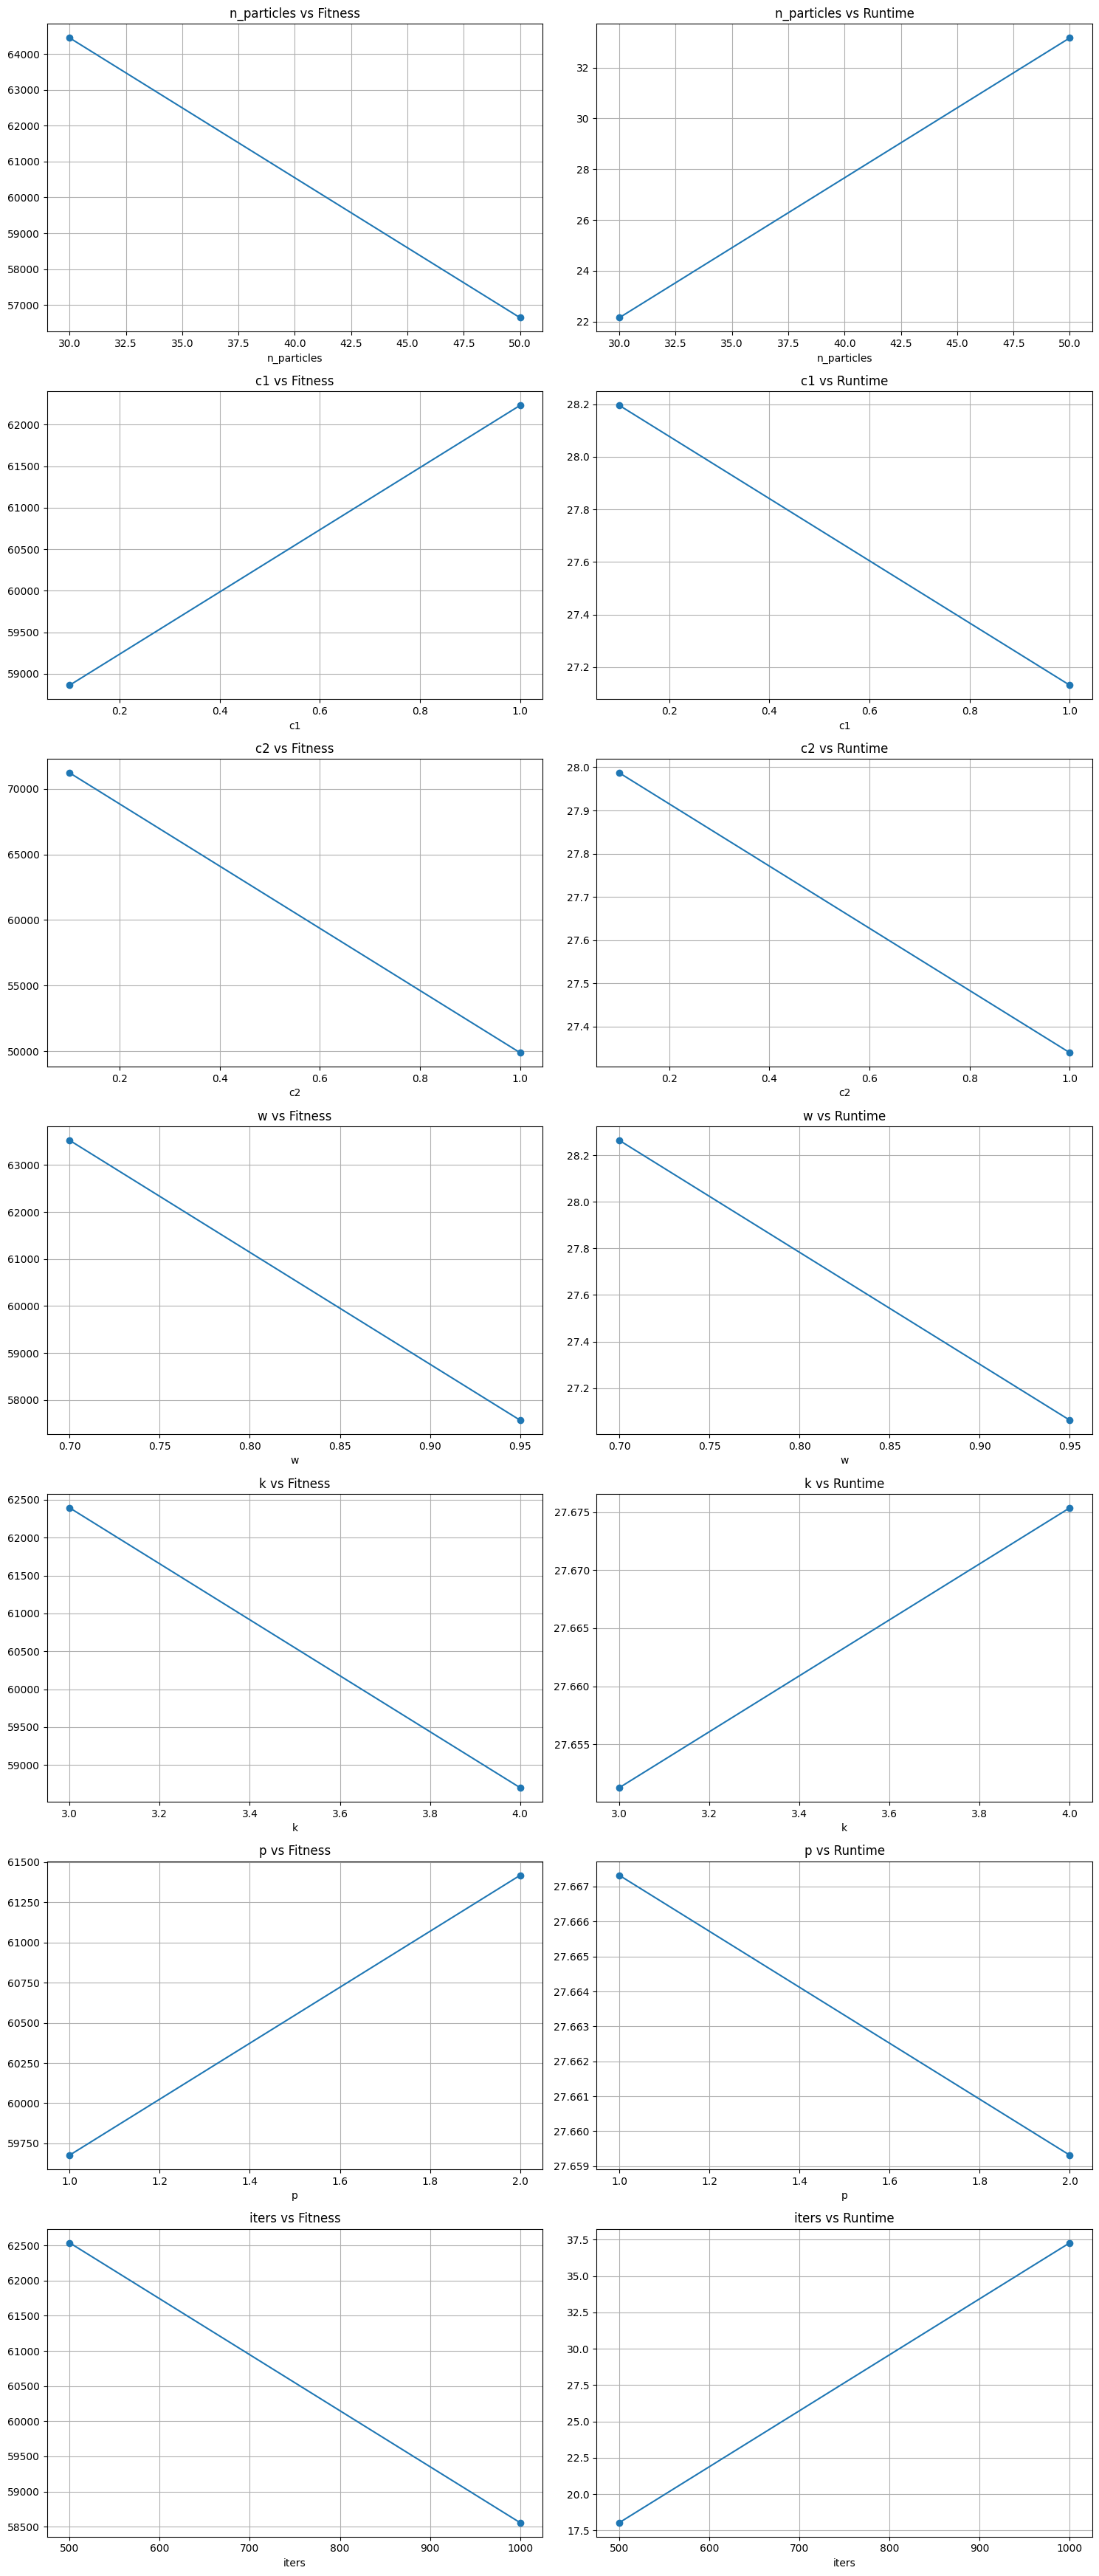


Best parameters found:
n_particles: 30.0
c1: 0.1
c2: 1.0
w: 0.7
k: 4.0
p: 2.0
iters: 1000.0

Final optimization results:
Best fitness: 11610.0
Runtime: 35.04 seconds

Best schedule found:

Violations Summary:
Consecutive module intake violations: 0
RMCE module intake violations: 1
Concurrent module violations: 0
SE student constraint violations: 24
DSBA student constraint violations: 137

Violations by Student:
Student ABC0074: 5 violations
Student ABC0109: 3 violations
Student ABC0110: 5 violations
Student ABC0201: 3 violations
Student ABC0202: 5 violations
Student ABC0503: 3 violations

SE Student Suggestions:
ABC0013: ['-', '-', '-', '-', '-']
ABC0074: ['RMCE | RMCP', '-', '-', '-', 'OOSSE']
ABC0099: ['-', '-', '-', '-', '-']
ABC0106: ['-', '-', '-', '-', '-']
ABC0109: ['RMCE | RMCP', '-', '-', '-', 'OOSSE']
ABC0110: ['-', '-', '-', '-', '-']
ABC0112: ['-', '-', '-', '-', '-']
ABC0122: ['RMCE | RMCP', 'SESE', '-', 'SQE', 'OOSSE']
ABC0145: ['-', '-', '-', '-', '-']
ABC0184: ['RMCE |

In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
from pyswarms.single import LocalBestPSO
import itertools
import time
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import random

class Schedule:
    def __init__(self, hardConstraintPenalty):
        self.hardConstraintPenalty = hardConstraintPenalty
        self.intakes = ['Jan', 'Mar', 'Jun', 'Aug', 'Oct']
        self.programme = ['SE', 'DSBA']
        self.modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'IA', 'NDP', 'RMCE | RMCP', 'BDAT', 'DM', 'MDA | NLP', 
                       'BIS', 'AML', 'MMDA', 'DAP', 'ABAV', 'BSSMMA | CIS', 'TSF | DL', 'SEM | DPM', 'ORO | BIA']
        self.slot_intake = 4
        
        # Load both SE and DSBA student data
        self.SE_students_data = self.load_SE_student_data()
        self.DSBA_students_data = self.load_DSBA_student_data()
        
        # Process both SE and DSBA student data
        self.SE_incomplete_modules, self.SE_completed_modules = self.process_SE_student_data()
        self.DSBA_incomplete_modules, self.DSBA_completed_modules = self.process_DSBA_student_data()
                  
    def __len__(self):
        return len(self.intakes) * self.slot_intake * len(self.programme)
    
    def getIntakeSchedule(self, schedule):
        programme_schedule = {programme: {intake: [] for intake in self.intakes} for programme in self.programme}
        index = 0

        for programme in self.programme:
            for intake in self.intakes:
                for _ in range(self.slot_intake):
                    if index < len(schedule):
                        module = self.modules[schedule[index]]
                        programme_schedule[programme][intake].append(module)
                        index += 1
        return programme_schedule
    
    def load_SE_student_data(self):
        SE_students_data = pd.read_excel("data_v1.xlsx")
        SE_students_data = SE_students_data[SE_students_data['COURSE_DESCRIPTION'] != 'MSc in Data Science and Business Analytics']
        SE_students_data = SE_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Managing Software Development Projects': 'MSDP',
            'Reliability Management': 'RM',
            'Object-Oriented Software Systems Engineering': 'OOSSE',
            'Object Oriented Software Systems Engineering': 'OOSSE',
            'Software Engineering Support Environments': 'SESE',
            'Software Quality Engineering': 'SQE',
            'Security Technologies': 'ST',
            'Research Methodology in Computing and Engineering': 'RMCE | RMCP',
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Internet Applications': 'IA',
            'Natural Language Processing': 'MDA | NLP',
            'Network Design and Performance': 'NDP'
        }

        SE_students_data['MODULE_NAME'] = SE_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'RMCE | RMCP', 'BDAT', 'DM', 'IA', 'MDA | NLP', 'NDP']
        SE_students_data = SE_students_data[SE_students_data['MODULE_NAME'].isin(valid_modules)]

        # Handle duplicates
        duplicated_modules = SE_students_data[SE_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)

        SE_students_data = pd.concat([SE_students_data.drop(index=duplicated_modules.index), filtered_students])
        SE_students_data.reset_index(drop=True, inplace=True)
                
        return SE_students_data
    
    def process_SE_student_data(self):
        SE_each_student_info = self.SE_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()
        
        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in SE_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)
        
        # Handle elective modules
        elective = ["BDAT", "DM", "IA", "MDA | NLP", "NDP"]
        for student_id, completed_modules_info in completed_modules.items():
            completed_elective = set(completed_modules_info) & set(elective)

            if len(completed_elective) >= 3:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)
        
        return incomplete_modules, completed_modules
    
    def calculate_SE_student_violations(self, programme_schedule):
        total_violations = 0
        se_schedule = programme_schedule['SE']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.SE_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0
            
            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(se_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 1
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 1)
            # Or if RMCE | RMCP is already completed, reduce violations by 1
            elif (student_id in self.SE_completed_modules and 
                'RMCE | RMCP' in self.SE_completed_modules[student_id]):
                violations = max(0, violations - 1)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations

    def load_DSBA_student_data(self):
        DSBA_students_data = pd.read_excel("data_v1.xlsx")
        DSBA_students_data = DSBA_students_data[DSBA_students_data['COURSE_DESCRIPTION'] != 'MSc in Software Engineering']
        DSBA_students_data = DSBA_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Business Intelligence Systems': 'BIS',
            'Applied Machine Learning': 'AML',
            'Applied Machine Learning ': 'AML',
            'Research Methods for Capstone Project': 'RMCP',
            'Research Methodology for Capstone Project': 'RMCP',
            'Research Methodology in Computing and Engineering': 'RMCP',
            'Research Methodology': 'RMCP',
            'Research Methods for Capstone Project': 'RMCP',
            'Multivariate Methods for Data Analysis': 'MMDA',
            'Data Analytical Programming': 'DAP',
            'Advanced Business Analytics and Visualization': 'ABAV',
            'Advanced Business Analytics and Visualisation': 'ABAV',
            'Behavioural Science, Social Media and Marketing Analytics': 'BSSMMA',
            'Behavioural Science,Social Media and Marketing Analytics': 'BSSMMA',
            'Cloud Infrastructure and Services': 'CIS',
            'Time Series Analysis and Forecasting': 'TSF',
            'Time Series Analysis and Forecasting ': 'TSF',
            'Deep Learning': 'DL',
            'Multilevel Data Analysis': 'MDA',
            'Natural Language Processing': 'NLP',
            'Strategies in Emerging Markets': 'SEM',
            'Data Protection and Management': 'DPM',
            'Operational Research and Optimisation': 'ORO',
            'Operational Research Optimisation': 'ORO',
            'Building IoT Applications': 'BIA'
        }

        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['BDAT', 'DM', 'BIS', 'AML', 'RMCP', 'MMDA', 'DAP', 'ABAV', 'BSSMMA', 'CIS',
                        'TSF', 'DL', 'MDA', 'NLP', 'SEM', 'DPM', 'ORO', 'BIA']
        DSBA_students_data = DSBA_students_data[DSBA_students_data['MODULE_NAME'].isin(valid_modules)]
        
        duplicated_modules = DSBA_students_data[DSBA_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]

        # handle duplicates
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grade function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)
        DSBA_students_data = pd.concat([DSBA_students_data.drop(index=duplicated_modules.index), filtered_students])
        
        # Handle DSBA special cases
        DSBA_students_data = self.handle_DSBA_special_cases(DSBA_students_data)

        # Final module name changes
        final_module_changes = {
            'RMCP': 'RMCE | RMCP',
            'NLP': 'MDA | NLP',
            'MDA': 'MDA | NLP',
            'BSSMMA': 'BSSMMA | CIS',
            'CIS': 'BSSMMA | CIS',
            'TSF': 'TSF | DL',
            'DL': 'TSF | DL',
            'SEM': 'SEM | DPM',
            'DPM': 'SEM | DPM',
            'ORO': 'ORO | BIA',
            'BIA': 'ORO | BIA'
        }
        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(final_module_changes)
        
        return DSBA_students_data

    def handle_DSBA_special_cases(self, df):
        # Function to check if student has specific modules
        def has_modules(group, module_set):
            return module_set.issubset(group['MODULE_NAME'].unique())
        
        # Handle BSSMMA, TSF, CIS case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "CIS"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'CIS')
        df = df[~rows_to_drop]
        
        # Handle BSSMMA, TSF, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'DL')
        df = df[~rows_to_drop]

        # Handle TSF, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"TSF", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'TSF')
        df = df[~rows_to_drop]

        # Handle BSSMMA, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'BSSMMA')
        df = df[~rows_to_drop]

        # Filter out non BI pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"NLP", "DPM", "BIA"})] 
            if {"BSSMMA", "TSF"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )
        
        # Filter out non DE pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"MDA", "SEM", "ORO"})] 
            if {"CIS", "DL"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )

        return df

    def process_DSBA_student_data(self):
        DSBA_each_student_info = self.DSBA_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()

        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in DSBA_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)

        # Handle electives
        elective = ["MDA | NLP", "SEM | DPM", "ORO | BIA"]
        for student_id in completed_modules:
            completed_elective = set(completed_modules[student_id]) & set(elective)
            if len(completed_elective) >= 1:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)

        return incomplete_modules, completed_modules

    def calculate_DSBA_student_violations(self, programme_schedule):
        total_violations = 0
        dsba_schedule = programme_schedule['DSBA']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.DSBA_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0

            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(dsba_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                    
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 2
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 2)
            # Or if RMCE | RMCP is already completed, reduce violations by 2
            elif (student_id in self.DSBA_completed_modules and 
                'RMCE | RMCP' in self.DSBA_completed_modules[student_id]):
                violations = max(0, violations - 2)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations
    
    def getCost(self, schedule):
        if not self.isValidProgrammeRanges(schedule):
            return float('inf')
            
        module_dict = self.getIntakeSchedule(schedule)
        consecutivemoduleintake = self.countConsecutivemoduleintake(module_dict)
        rmce_violations = self.rmceintake(module_dict)
        concurrent_violations = self.concurrentModuleViolations(module_dict)
        se_student_violations, _, _ = self.calculate_SE_student_violations(module_dict)
        dsba_student_violations, _, _ = self.calculate_DSBA_student_violations(module_dict)
        
        hardContstraintViolations = (
            consecutivemoduleintake*1000 +
            rmce_violations*1000 +
            concurrent_violations*1000 +
            se_student_violations +
            dsba_student_violations)
        
        return self.hardConstraintPenalty * hardContstraintViolations

    def isValidProgrammeRanges(self, schedule):
        slots_per_programme = len(self.intakes) * self.slot_intake
        
        se_modules = schedule[:slots_per_programme]
        if not all(0 <= module <= 11 for module in se_modules):
            return False
            
        dsba_modules = schedule[slots_per_programme:]
        if not all(8 <= module <= 20 for module in dsba_modules):
            return False
            
        return True  
    
    def countConsecutivemoduleintake(self, programme_schedule):
        violations = 0
        for programme, intakes in programme_schedule.items():
            intakes_list = list(intakes.values())
            for i in range(len(intakes_list) - 1):
                intake_1 = intakes_list[i]
                intake_2 = intakes_list[i + 1]

                for module in intake_1:
                    if module in intake_2:
                        violations += 1
        return violations

    def rmceintake(self, programme_schedule):
        violations = 0
        required_intakes = ['Jan', 'Jun', 'Oct']

        for programme, intakes in programme_schedule.items():
            for intake in required_intakes:
                if intake in intakes:
                    if 'RMCE | RMCP' not in intakes[intake]:
                        violations += 1
        return violations
    
    def concurrentModuleViolations(self, programme_schedule):
        violations = 0
        matching_dict_SE = {}
        matching_dict_DSBA = {}
        concurrent_modules = ['BDAT', 'DM', 'MDA | NLP']
        
        # Check SE programme
        for intake, se_modules in programme_schedule['SE'].items():
            matching_modules = [module for module in concurrent_modules if module in se_modules]
            if matching_modules:
                matching_dict_SE[intake] = matching_modules
                  
        # Check DSBA programme
        for intake, dsba_modules in programme_schedule['DSBA'].items():
            matching_modules = [module for module in concurrent_modules if module in dsba_modules]
            if matching_modules:
                matching_dict_DSBA[intake] = matching_modules
            
        intakes = set(matching_dict_SE.keys()).union(matching_dict_DSBA.keys())
        
        # Compare for each intake
        for intake in intakes:
            if intake in matching_dict_SE and intake in matching_dict_DSBA:
                if matching_dict_DSBA[intake] != matching_dict_SE[intake]:
                    violations += 1
                elif matching_dict_SE[intake] != matching_dict_DSBA[intake]:
                    violations +=1
            else:
                violations +=1
                        
        return violations

    def removeDuplicatedModules(self, programme_schedule):
        for programme, intakes in programme_schedule.items():
            for intake, modules in intakes.items():
                seen_modules = set()
                unique_modules = []
                for module in modules:
                    if module not in seen_modules:
                        unique_modules.append(module)
                        seen_modules.add(module)
                intakes[intake] = unique_modules  # Update intake with unique modules
        return programme_schedule
    
    def print_schedule(self, schedule):
        programme_schedule = self.getIntakeSchedule(schedule)
        
        # Remove duplicates before printing
        programme_schedule = self.removeDuplicatedModules(programme_schedule)

        # print("Schedule for each intake and programme:")
        # for programme, intakes in programme_schedule.items():
        #     print(f"\nProgramme: {programme}")
        #     for intake, modules in intakes.items():
        #         print(f"  Intake {intake}: {', '.join(modules) if modules else 'No modules assigned'}")

        se_violations, se_suggestions, se_student_violations = self.calculate_SE_student_violations(programme_schedule)
        dsba_violations, dsba_suggestions, dsba_student_violations = self.calculate_DSBA_student_violations(programme_schedule)
        
        print("\nViolations Summary:")
        print(f"Consecutive module intake violations: {self.countConsecutivemoduleintake(programme_schedule)}")
        print(f"RMCE module intake violations: {self.rmceintake(programme_schedule)}")
        print(f"Concurrent module violations: {self.concurrentModuleViolations(programme_schedule)}")
        print(f"SE student constraint violations: {se_violations}")
        print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in se_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nSE Student Suggestions:")
        for student_id, modules in se_suggestions.items():
            print(f"{student_id}: {modules}") 
        
        # print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in dsba_student_violations.items():
            if violations > 0:
                print(f"Student {student_id}: {violations} violations")
        print("\nDSBA Student Suggestions:")
        for student_id, modules in dsba_suggestions.items():
            print(f"{student_id}: {modules}")
class PSOSchedule(Schedule):
    def __init__(self, hardConstraintPenalty):
        super().__init__(hardConstraintPenalty)
        self.n_dimensions = len(self.intakes) * self.slot_intake * len(self.programme)
        
    def objectiveFunction(self, positions):
        costs = []
        for position in positions:
            schedule = self.convertToSchedule(position)
            cost = self.getCost(schedule)
            costs.append(cost)
        return np.array(costs)
    
    def convertToSchedule(self, position):
        slots_per_programme = len(self.intakes) * self.slot_intake
        schedule = []
        
        # Convert SE modules (first half)
        se_positions = position[:slots_per_programme]
        se_schedule = np.round(se_positions * (11 / 100)).astype(int)
        se_schedule = np.clip(se_schedule, 0, 11)
        
        # Convert DSBA modules (second half)
        dsba_positions = position[slots_per_programme:]
        dsba_schedule = np.round(8 + (dsba_positions * (12 / 100))).astype(int)
        dsba_schedule = np.clip(dsba_schedule, 8, 20)
        
        schedule = list(se_schedule) + list(dsba_schedule)
        return schedule

    def optimize(self):
        # Set bounds for particle positions
        max_bound = 100 * np.ones(self.n_dimensions)
        min_bound = np.zeros(self.n_dimensions)
        bounds = (min_bound, max_bound)
        np.random.seed(42)
        # Initialize swarm
        options = {
            'c1': 0.1,  # cognitive
            'c2': 0.1,  # social
            'w': 0.95,   # inertia
            'k': 4,
            'p': 1
        }

        optimizer = LocalBestPSO(
            n_particles=30,
            dimensions=self.n_dimensions,
            options=options,
            bounds=bounds
        )

        # Optimize
        best_cost, best_pos = optimizer.optimize(
            self.objectiveFunction,
            iters=1000,
            verbose=True
        )

        # Convert best position to schedule
        best_schedule = self.convertToSchedule(best_pos)
        
        return best_schedule, best_cost
    
def run_pso_with_params(schedule, n_particles, c1, c2, w, k, p, iters, seed=42):
    """
    Run PSO with specified parameters and return best fitness
    """
    np.random.seed(seed)
    
    # Set bounds
    max_bound = 100 * np.ones(schedule.n_dimensions)
    min_bound = np.zeros(schedule.n_dimensions)
    bounds = (min_bound, max_bound)
    
    # Initialize options
    options = {
        'c1': c1,
        'c2': c2,
        'w': w,
        'k': k,
        'p': p
    }
    
    start_time = time.time()
    
    # Initialize optimizer
    optimizer = LocalBestPSO(
        n_particles=n_particles,
        dimensions=schedule.n_dimensions,
        options=options,
        bounds=bounds
    )
    
    # Run optimization
    best_cost, best_pos = optimizer.optimize(
        schedule.objectiveFunction,
        iters=iters,
        verbose=False
    )
    
    runtime = time.time() - start_time
    
    # Get final schedule
    best_schedule = schedule.convertToSchedule(best_pos)
    
    return {
        'best_fitness': float(best_cost),
        'runtime': runtime,
        'final_schedule': best_schedule
    }

def grid_search_pso(schedule):
    """
    Perform grid search for PSO parameters
    """
    # Define parameter ranges
    param_grid = {
        'n_particles': [30, 50],
        'c1': [0.1, 1.0],
        'c2': [0.1, 1.0],
        'w': [0.7, 0.95],
        'k': [3, 4],
        'p': [1, 2],
        'iters': [500, 1000]
    }
    
    # Create all combinations of parameters
    param_combinations = [dict(zip(param_grid.keys(), v)) 
                        for v in itertools.product(*param_grid.values())]
    
    results = []
    
    # Test each combination
    for params in param_combinations:
        print(f"Testing parameters: {params}")
        
        # Run multiple trials for statistical significance
        n_trials = 3
        trial_results = []
        
        for trial in range(n_trials):
            result = run_pso_with_params(
                schedule,
                params['n_particles'],
                params['c1'],
                params['c2'],
                params['w'],
                params['k'],
                params['p'],
                params['iters'],
                seed=42+trial
            )
            trial_results.append(result)
        
        # Average results across trials
        avg_result = {
            'n_particles': params['n_particles'],
            'c1': params['c1'],
            'c2': params['c2'],
            'w': params['w'],
            'k': params['k'],
            'p': params['p'],
            'iters': params['iters'],
            'best_fitness': np.mean([r['best_fitness'] for r in trial_results]),
            'runtime': np.mean([r['runtime'] for r in trial_results])
        }
        
        results.append(avg_result)
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    # Score results (weighted combination of fitness and runtime)
    results_df['score'] = results_df['best_fitness'] * 0.8 + \
                         results_df['runtime'].rank(pct=True) * 0.2
    
    return results_df

def plot_parameter_effects(results_df):
    """
    Plot the effect of each parameter on fitness and runtime
    """
    parameters = ['n_particles', 'c1', 'c2', 'w', 'k', 'p', 'iters']
    
    fig, axes = plt.subplots(len(parameters), 2, figsize=(15, 5*len(parameters)))
    
    for i, param in enumerate(parameters):
        # Plot effect on fitness
        results_df.groupby(param)['best_fitness'].mean().plot(
            ax=axes[i,0], marker='o'
        )
        axes[i,0].set_title(f'{param} vs Fitness')
        axes[i,0].grid(True)
        
        # Plot effect on runtime
        results_df.groupby(param)['runtime'].mean().plot(
            ax=axes[i,1], marker='o'
        )
        axes[i,1].set_title(f'{param} vs Runtime')
        axes[i,1].grid(True)
    
    plt.tight_layout()
    plt.show()

def main():
    # Initialize schedule
    schedule = PSOSchedule(hardConstraintPenalty=10)
    
    # Run grid search
    results = grid_search_pso(schedule)
    
    # Print top 5 parameter combinations
    print("\nTop 3 parameter combinations:")
    print(results.sort_values('score').head(3))
    
    # Plot parameter effects
    plot_parameter_effects(results)
    
    # Get best parameters
    best_params = results.loc[results['score'].idxmin()]
    print("\nBest parameters found:")
    for param in ['n_particles', 'c1', 'c2', 'w', 'k', 'p', 'iters']:
        print(f"{param}: {best_params[param]}")
    
    # Run final optimization with best parameters
    final_result = run_pso_with_params(
        schedule,
        int(best_params['n_particles']),
        best_params['c1'],
        best_params['c2'],
        best_params['w'],
        int(best_params['k']),
        int(best_params['p']),
        int(best_params['iters'])
    )
    
    print("\nFinal optimization results:")
    print(f"Best fitness: {final_result['best_fitness']}")
    print(f"Runtime: {final_result['runtime']:.2f} seconds")
    
    # Print final schedule
    print("\nBest schedule found:")
    schedule.print_schedule(final_result['final_schedule'])

if __name__ == "__main__":
    main()

Optimized PSO

In [3]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
from pyswarms.single import GlobalBestPSO, LocalBestPSO
import random

class Schedule:
    def __init__(self, hardConstraintPenalty):
        self.hardConstraintPenalty = hardConstraintPenalty
        self.intakes = ['Jan', 'Mar', 'Jun', 'Aug', 'Oct']
        self.programme = ['SE', 'DSBA']
        self.modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'IA', 'NDP', 'RMCE | RMCP', 'BDAT', 'DM', 'MDA | NLP', 
                       'BIS', 'AML', 'MMDA', 'DAP', 'ABAV', 'BSSMMA | CIS', 'TSF | DL', 'SEM | DPM', 'ORO | BIA']
        self.slot_intake = 4
        
        # Load both SE and DSBA student data
        self.SE_students_data = self.load_SE_student_data()
        self.DSBA_students_data = self.load_DSBA_student_data()
        
        # Process both SE and DSBA student data
        self.SE_incomplete_modules, self.SE_completed_modules = self.process_SE_student_data()
        self.DSBA_incomplete_modules, self.DSBA_completed_modules = self.process_DSBA_student_data()
                  
    def __len__(self):
        return len(self.intakes) * self.slot_intake * len(self.programme)
    
    def getIntakeSchedule(self, schedule):
        programme_schedule = {programme: {intake: [] for intake in self.intakes} for programme in self.programme}
        index = 0

        for programme in self.programme:
            for intake in self.intakes:
                for _ in range(self.slot_intake):
                    if index < len(schedule):
                        module = self.modules[schedule[index]]
                        programme_schedule[programme][intake].append(module)
                        index += 1
        return programme_schedule
    
    def load_SE_student_data(self):
        SE_students_data = pd.read_excel("data_v1.xlsx")
        SE_students_data = SE_students_data[SE_students_data['COURSE_DESCRIPTION'] != 'MSc in Data Science and Business Analytics']
        SE_students_data = SE_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Managing Software Development Projects': 'MSDP',
            'Reliability Management': 'RM',
            'Object-Oriented Software Systems Engineering': 'OOSSE',
            'Object Oriented Software Systems Engineering': 'OOSSE',
            'Software Engineering Support Environments': 'SESE',
            'Software Quality Engineering': 'SQE',
            'Security Technologies': 'ST',
            'Research Methodology in Computing and Engineering': 'RMCE | RMCP',
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Internet Applications': 'IA',
            'Natural Language Processing': 'MDA | NLP',
            'Network Design and Performance': 'NDP'
        }

        SE_students_data['MODULE_NAME'] = SE_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['MSDP', 'RM', 'OOSSE', 'SESE', 'SQE', 'ST', 'RMCE | RMCP', 'BDAT', 'DM', 'IA', 'MDA | NLP', 'NDP']
        SE_students_data = SE_students_data[SE_students_data['MODULE_NAME'].isin(valid_modules)]

        # Handle duplicates
        duplicated_modules = SE_students_data[SE_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)

        SE_students_data = pd.concat([SE_students_data.drop(index=duplicated_modules.index), filtered_students])
        SE_students_data.reset_index(drop=True, inplace=True)
                
        return SE_students_data
    
    def process_SE_student_data(self):
        SE_each_student_info = self.SE_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()
        
        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in SE_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)
        
        # Handle elective modules
        elective = ["BDAT", "DM", "IA", "MDA | NLP", "NDP"]
        for student_id, completed_modules_info in completed_modules.items():
            completed_elective = set(completed_modules_info) & set(elective)

            if len(completed_elective) >= 3:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)
        
        return incomplete_modules, completed_modules
    
    def calculate_SE_student_violations(self, programme_schedule):
        total_violations = 0
        se_schedule = programme_schedule['SE']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.SE_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0
            
            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(se_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # Assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 1
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 1)
            # Or if RMCE | RMCP is already completed, reduce violations by 1
            elif (student_id in self.SE_completed_modules and 
                'RMCE | RMCP' in self.SE_completed_modules[student_id]):
                violations = max(0, violations - 1)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations

    def load_DSBA_student_data(self):
        DSBA_students_data = pd.read_excel("data_v1.xlsx")
        DSBA_students_data = DSBA_students_data[DSBA_students_data['COURSE_DESCRIPTION'] != 'MSc in Software Engineering']
        DSBA_students_data = DSBA_students_data.drop(["INTAKE_CODE", "MODULE_CODE", "STUDY_MODE"], axis=1)

        module_name_changes = {
            'Big Data Analytics and Technologies': 'BDAT',
            'Data Management': 'DM',
            'Business Intelligence Systems': 'BIS',
            'Applied Machine Learning': 'AML',
            'Applied Machine Learning ': 'AML',
            'Research Methods for Capstone Project': 'RMCP',
            'Research Methodology for Capstone Project': 'RMCP',
            'Research Methodology in Computing and Engineering': 'RMCP',
            'Research Methodology': 'RMCP',
            'Research Methods for Capstone Project': 'RMCP',
            'Multivariate Methods for Data Analysis': 'MMDA',
            'Data Analytical Programming': 'DAP',
            'Advanced Business Analytics and Visualization': 'ABAV',
            'Advanced Business Analytics and Visualisation': 'ABAV',
            'Behavioural Science, Social Media and Marketing Analytics': 'BSSMMA',
            'Behavioural Science,Social Media and Marketing Analytics': 'BSSMMA',
            'Cloud Infrastructure and Services': 'CIS',
            'Time Series Analysis and Forecasting': 'TSF',
            'Time Series Analysis and Forecasting ': 'TSF',
            'Deep Learning': 'DL',
            'Multilevel Data Analysis': 'MDA',
            'Natural Language Processing': 'NLP',
            'Strategies in Emerging Markets': 'SEM',
            'Data Protection and Management': 'DPM',
            'Operational Research and Optimisation': 'ORO',
            'Operational Research Optimisation': 'ORO',
            'Building IoT Applications': 'BIA'
        }

        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(module_name_changes)
        valid_modules = ['BDAT', 'DM', 'BIS', 'AML', 'RMCP', 'MMDA', 'DAP', 'ABAV', 'BSSMMA', 'CIS',
                        'TSF', 'DL', 'MDA', 'NLP', 'SEM', 'DPM', 'ORO', 'BIA']
        DSBA_students_data = DSBA_students_data[DSBA_students_data['MODULE_NAME'].isin(valid_modules)]
        
        duplicated_modules = DSBA_students_data[DSBA_students_data.duplicated(['STUDENT_NUMBER', 'MODULE_NAME'], keep=False)]

        # Handle duplicates
        def filter_grades(group):
            if group['GRADE'].notna().sum() > 0:
                return group[group['GRADE'].notna()].drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')
            else:
                return group.drop_duplicates(subset=['STUDENT_NUMBER', 'MODULE_NAME'], keep='first')

        # Apply the filter_grades function
        filtered_students = duplicated_modules.groupby(['STUDENT_NUMBER', 'MODULE_NAME']).apply(filter_grades).reset_index(drop=True)
        DSBA_students_data = pd.concat([DSBA_students_data.drop(index=duplicated_modules.index), filtered_students])

        # Handle DSBA special cases
        DSBA_students_data = self.handle_DSBA_special_cases(DSBA_students_data)

        # Final module name changes
        final_module_changes = {
            'RMCP': 'RMCE | RMCP',
            'NLP': 'MDA | NLP',
            'MDA': 'MDA | NLP',
            'BSSMMA': 'BSSMMA | CIS',
            'CIS': 'BSSMMA | CIS',
            'TSF': 'TSF | DL',
            'DL': 'TSF | DL',
            'SEM': 'SEM | DPM',
            'DPM': 'SEM | DPM',
            'ORO': 'ORO | BIA',
            'BIA': 'ORO | BIA'
        }
        DSBA_students_data['MODULE_NAME'] = DSBA_students_data['MODULE_NAME'].replace(final_module_changes)
        
        return DSBA_students_data

    def handle_DSBA_special_cases(self, df):
        # Function to check if student has specific modules
        def has_modules(group, module_set):
            return module_set.issubset(group['MODULE_NAME'].unique())

        # Handle BSSMMA, TSF, CIS case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "CIS"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'CIS')
        df = df[~rows_to_drop]
        
        # Handle BSSMMA, TSF, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "TSF", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'DL')
        df = df[~rows_to_drop]

        # Handle TSF, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"TSF", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'TSF')
        df = df[~rows_to_drop]

        # Handle BSSMMA, CIS, DL case
        students_with_all = df.groupby('STUDENT_NUMBER').filter(lambda x: has_modules(x, {"BSSMMA", "CIS", "DL"}))
        rows_to_drop = (df['STUDENT_NUMBER'].isin(students_with_all['STUDENT_NUMBER'].unique())) & (df['MODULE_NAME'] == 'BSSMMA')
        df = df[~rows_to_drop]

        # Filter out non BI pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"NLP", "DPM", "BIA"})] 
            if {"BSSMMA", "TSF"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )
        
        # Filter out non DE pathway modules
        df = df.groupby('STUDENT_NUMBER', group_keys=False).apply(
            lambda group: group[~group['MODULE_NAME'].isin({"MDA", "SEM", "ORO"})] 
            if {"CIS", "DL"}.issubset(group['MODULE_NAME'].unique()) 
            else group
        )

        return df

    def process_DSBA_student_data(self):
        DSBA_each_student_info = self.DSBA_students_data.groupby('STUDENT_NUMBER').apply(
            lambda x: {'Modules': x['MODULE_NAME'].tolist(), 'Grades': x['GRADE'].tolist()}
        ).to_dict()

        incomplete_modules = {}
        completed_modules = {}

        for student_id, modules_info in DSBA_each_student_info.items():
            modules = modules_info['Modules']
            grades = modules_info['Grades']

            incomplete_modules[student_id] = []
            completed_modules[student_id] = []

            for module, grade in zip(modules, grades):
                if pd.isna(grade) or grade in ["", "N/A"]:
                    incomplete_modules[student_id].append(module)
                else:
                    completed_modules[student_id].append(module)

        # Handle electives
        elective = ["MDA | NLP", "SEM | DPM", "ORO | BIA"]
        for student_id in completed_modules:
            completed_elective = set(completed_modules[student_id]) & set(elective)
            if len(completed_elective) >= 1:
                for student_id, incomplete_modules_info in incomplete_modules.items():
                    extra_elective = set(incomplete_modules_info) & set(elective)
                    for module in extra_elective:
                        completed_modules[student_id].append(module)
                        incomplete_modules_info.remove(module)

        return incomplete_modules, completed_modules

    def calculate_DSBA_student_violations(self, programme_schedule):
        total_violations = 0
        dsba_schedule = programme_schedule['DSBA']
        student_suggestions = {}
        student_violations = {}

        for student_id, incomplete_modules_info in self.DSBA_incomplete_modules.items():
            # Initialize student suggestions with "-" for each intake
            student_suggestions[student_id] = ['-'] * len(self.intakes)
            student_violations[student_id] = 0
            
            # Make a copy of incomplete modules list
            incomplete_modules_list = incomplete_modules_info.copy()
            
            # Store initial length of incomplete modules
            initial_modules_count = len(incomplete_modules_info)
            
            # If no incomplete modules, continue with all "-" and no violations
            if not incomplete_modules_list:
                continue

            rmce_assigned = False
            violations = 0

            # Process each intake
            for i, (intake, intake_modules_info) in enumerate(dsba_schedule.items()):
                # If no more modules to assign, stop checking for violations
                if not incomplete_modules_list:
                    break
                    
                # Prioritize to assign RMCE | RMCP if not yet assigned
                if not rmce_assigned and 'RMCE | RMCP' in incomplete_modules_list and 'RMCE | RMCP' in intake_modules_info:
                    student_suggestions[student_id][i] = 'RMCE | RMCP'
                    incomplete_modules_list.remove('RMCE | RMCP')
                    rmce_assigned = True
                    continue
                
                # assign for other modules
                module_assigned = False
                for module in incomplete_modules_list[:]:
                    if module in intake_modules_info:
                        student_suggestions[student_id][i] = module
                        incomplete_modules_list.remove(module)
                        module_assigned = True
                        break
                    
                # Only count a violation if couldn't assign a module and still have modules to assign
                if not module_assigned and incomplete_modules_list:
                    violations += 1
            # Add violations for remaining modules if initial count was ≤ 5
            if initial_modules_count <= 5 and incomplete_modules_list:
                violations += len(incomplete_modules_list)
            
            # If RMCE | RMCP is assigned, reduce violations by 2
            if 'RMCE | RMCP' in student_suggestions[student_id]:
                violations = max(0, violations - 2)
            # Or if RMCE | RMCP is already completed, reduce violations by 2
            elif (student_id in self.DSBA_completed_modules and 
                'RMCE | RMCP' in self.DSBA_completed_modules[student_id]):
                violations = max(0, violations - 2)
            
            student_violations[student_id] = violations
            total_violations += violations

        return total_violations, student_suggestions, student_violations
    
    def getCost(self, schedule):
        if not self.isValidProgrammeRanges(schedule):
            return float('inf')
            
        module_dict = self.getIntakeSchedule(schedule)
        consecutivemoduleintake = self.countConsecutivemoduleintake(module_dict)
        rmce_violations = self.rmceintake(module_dict)
        concurrent_violations = self.concurrentModuleViolations(module_dict)
        se_student_violations, _, _ = self.calculate_SE_student_violations(module_dict)
        dsba_student_violations, _, _ = self.calculate_DSBA_student_violations(module_dict)
        
        hardContstraintViolations = (
            consecutivemoduleintake*1000 +
            rmce_violations*1000 +
            concurrent_violations*1000 +
            se_student_violations +
            dsba_student_violations)
        
        return self.hardConstraintPenalty * hardContstraintViolations

    def isValidProgrammeRanges(self, schedule):
        slots_per_programme = len(self.intakes) * self.slot_intake
        
        se_modules = schedule[:slots_per_programme]
        if not all(0 <= module <= 11 for module in se_modules):
            return False
            
        dsba_modules = schedule[slots_per_programme:]
        if not all(8 <= module <= 20 for module in dsba_modules):
            return False
            
        return True  
    
    def countConsecutivemoduleintake(self, programme_schedule):
        violations = 0
        for programme, intakes in programme_schedule.items():
            intakes_list = list(intakes.values())
            for i in range(len(intakes_list) - 1):
                intake_1 = intakes_list[i]
                intake_2 = intakes_list[i + 1]

                for module in intake_1:
                    if module in intake_2:
                        violations += 1
        return violations

    def rmceintake(self, programme_schedule):
        violations = 0
        required_intakes = ['Jan', 'Jun', 'Oct']

        for programme, intakes in programme_schedule.items():
            for intake in required_intakes:
                if intake in intakes:
                    if 'RMCE | RMCP' not in intakes[intake]:
                        violations += 1
        return violations
    
    def concurrentModuleViolations(self, programme_schedule):
        violations = 0
        matching_dict_SE = {}
        matching_dict_DSBA = {}
        concurrent_modules = ['BDAT', 'DM', 'MDA | NLP']
        
        # Check SE programme
        for intake, se_modules in programme_schedule['SE'].items():
            matching_modules = [module for module in concurrent_modules if module in se_modules]
            if matching_modules:
                matching_dict_SE[intake] = matching_modules
                  
        # Check DSBA programme
        for intake, dsba_modules in programme_schedule['DSBA'].items():
            matching_modules = [module for module in concurrent_modules if module in dsba_modules]
            if matching_modules:
                matching_dict_DSBA[intake] = matching_modules
            
        intakes = set(matching_dict_SE.keys()).union(matching_dict_DSBA.keys())
        
        # Compare for each intake
        for intake in intakes:
            if intake in matching_dict_SE and intake in matching_dict_DSBA:
                if matching_dict_DSBA[intake] != matching_dict_SE[intake]:
                    violations += 1
                elif matching_dict_SE[intake] != matching_dict_DSBA[intake]:
                    violations +=1
            else:
                violations +=1
                        
        return violations

    def removeDuplicatedModules(self, programme_schedule):
        for programme, intakes in programme_schedule.items():
            for intake, modules in intakes.items():
                seen_modules = set()
                unique_modules = []
                for module in modules:
                    if module not in seen_modules:
                        unique_modules.append(module)
                        seen_modules.add(module)
                intakes[intake] = unique_modules
        return programme_schedule
    
    def print_schedule(self, schedule):
        programme_schedule = self.getIntakeSchedule(schedule)
        
        # Remove duplicates before printing
        programme_schedule = self.removeDuplicatedModules(programme_schedule)

        print("Schedule for each intake and programme:")
        for programme, intakes in programme_schedule.items():
            print(f"\nProgramme: {programme}")
            for intake, modules in intakes.items():
                print(f"  Intake {intake}: {', '.join(modules) if modules else 'No modules assigned'}")

        se_violations, se_suggestions, se_student_violations = self.calculate_SE_student_violations(programme_schedule)
        dsba_violations, dsba_suggestions, dsba_student_violations = self.calculate_DSBA_student_violations(programme_schedule)
        
        print("\nViolations Summary:")
        print(f"Consecutive module intake violations: {self.countConsecutivemoduleintake(programme_schedule)}")
        print(f"RMCE module intake violations: {self.rmceintake(programme_schedule)}")
        print(f"Concurrent module violations: {self.concurrentModuleViolations(programme_schedule)}")
        print(f"SE student constraint violations: {se_violations}")
        print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in se_student_violations.items():
            if violations > 0:  # Only print students with violations
                print(f"Student {student_id}: {violations} violations")
        print("\nSE Student Suggestions:")
        for student_id, modules in se_suggestions.items():
            print(f"{student_id}: {modules}") 
        
        # print(f"DSBA student constraint violations: {dsba_violations}")
        print("\nViolations by Student:")
        for student_id, violations in dsba_student_violations.items():
            if violations > 0:  # Only print students with violations
                print(f"Student {student_id}: {violations} violations")
        print("\nDSBA Student Suggestions:")
        for student_id, modules in dsba_suggestions.items():
            print(f"{student_id}: {modules}")

class PSOSchedule(Schedule):
    def __init__(self, hardConstraintPenalty):
        super().__init__(hardConstraintPenalty)
        self.n_dimensions = len(self.intakes) * self.slot_intake * len(self.programme)
        
    def objectiveFunction(self, positions):
        costs = []
        for position in positions:
            schedule = self.convertToSchedule(position)
            cost = self.getCost(schedule)
            costs.append(cost)
        return np.array(costs)
    
    def convertToSchedule(self, position):
        slots_per_programme = len(self.intakes) * self.slot_intake
        schedule = []
        
        # Convert SE modules (first half)
        se_positions = position[:slots_per_programme]
        se_schedule = np.round(se_positions * (11 / 100)).astype(int)
        se_schedule = np.clip(se_schedule, 0, 11)
        
        # Convert DSBA modules (second half)
        dsba_positions = position[slots_per_programme:]
        dsba_schedule = np.round(8 + (dsba_positions * (12 / 100))).astype(int)
        dsba_schedule = np.clip(dsba_schedule, 8, 20)
        
        schedule = list(se_schedule) + list(dsba_schedule)
        return schedule

    def optimize(self):
        # Set bounds for particle positions
        max_bound = 100 * np.ones(self.n_dimensions)
        min_bound = np.zeros(self.n_dimensions)
        bounds = (min_bound, max_bound)
        np.random.seed(42)
        # Initialize swarm
        options = {
            'c1': 0.1,  # cognitive
            'c2': 1.0,  # social
            'w': 0.7,   # inertia
            'k': 4,
            'p': 2
        }

        optimizer = LocalBestPSO(
            n_particles=30,
            dimensions=self.n_dimensions,
            options=options,
            bounds=bounds
        )

        # Optimize
        best_cost, best_pos = optimizer.optimize(
            self.objectiveFunction,
            iters=1000,
            verbose=True
        )

        best_schedule = self.convertToSchedule(best_pos)
        
        return best_schedule, best_cost

if __name__ == "__main__":
    pso_scheduler = PSOSchedule(hardConstraintPenalty=10)
    best_schedule, best_cost = pso_scheduler.optimize()
    
    print("\nOptimization Results:")
    print("Best Cost:", best_cost)
    print("Best Schedule:", best_schedule)
    print("\nDetailed Schedule:")
    pso_scheduler.print_schedule(best_schedule)

2025-02-03 12:46:45,815 - pyswarms.single.local_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 1.0, 'w': 0.7, 'k': 4, 'p': 2}
pyswarms.single.local_best: 100%|██████████|1000/1000, best_cost=11610.0
2025-02-03 12:47:25,125 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 11610.0, best pos: [62.29966044 66.92291061 73.11401811 53.1127847  27.19364156 35.22233122
 23.78998335 34.24445566 54.30394679 52.19248388 70.23928759 73.83247795
 33.83157503 63.10904085 64.94630156 38.79749534 53.59868296 22.23073921
 70.74501874 54.05530593 46.41068409  1.80799844 65.81519288 67.85481365
 30.58730586 44.71266527 34.43637847 34.99301074 53.16099357 53.97936137
 63.4161221  60.06876375 31.05235316 41.50979019 41.51143833 33.00927764
 61.80646211 55.90613105 74.44956952  3.80183236]



Optimization Results:
Best Cost: 11610.0
Best Schedule: [np.int64(7), np.int64(7), np.int64(8), np.int64(6), np.int64(3), np.int64(4), np.int64(3), np.int64(4), np.int64(6), np.int64(6), np.int64(8), np.int64(8), np.int64(4), np.int64(7), np.int64(7), np.int64(4), np.int64(6), np.int64(2), np.int64(8), np.int64(6), np.int64(14), np.int64(8), np.int64(16), np.int64(16), np.int64(12), np.int64(13), np.int64(12), np.int64(12), np.int64(14), np.int64(14), np.int64(16), np.int64(15), np.int64(12), np.int64(13), np.int64(13), np.int64(12), np.int64(15), np.int64(15), np.int64(17), np.int64(8)]

Detailed Schedule:
Schedule for each intake and programme:

Programme: SE
  Intake Jan: NDP, RMCE | RMCP, IA
  Intake Mar: SESE, SQE
  Intake Jun: IA, RMCE | RMCP
  Intake Aug: SQE, NDP
  Intake Oct: IA, OOSSE, RMCE | RMCP

Programme: DSBA
  Intake Jan: MMDA, RMCE | RMCP, ABAV
  Intake Mar: BIS, AML
  Intake Jun: MMDA, ABAV, DAP
  Intake Aug: BIS, AML
  Intake Oct: DAP, BSSMMA | CIS, RMCE | RMCP

Vio